# Prolem Set 2

**Author:** Study Group 4 
Dante, Ellie, Loren, Praneeth, Savannah, Brandon, Jan 

**Date:**
9.11.2025

In [35]:
# Import required libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm         # colour palettes for visuals
import matplotlib.ticker as mtick  # used in building visuals
import warnings                    # this is used to control how warnings are handled in our project
import janitor                     # Used for data cleaning
import geopandas as gpd      # for working with geospatial data
from IPython.display import Image, display  # for displaying images in Jupyter Notebooks
import plotly.express as px  # for interactive visualizations


warnings.filterwarnings('ignore')  # we have decided to suppress all warning messages for this project

# Using "white" provides a clean background without grid lines, which is ideal for maps.
sns.set_theme(style="white")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (6.75, 6.75)


# 2024 US County Level Presidential Results
Try to recreate the county level margins for the 2024 elections.
This maps was created using the shapefile from https://urbaninstitute.github.io/urbnmapr/ 

In [36]:
# filename = 'challenge1.png'

# # Display the image
# display(Image(filename))



In [ ]:
# Load  data

# Load the votes by county dataset from the relevant directory
us_elections_2024 = pd.read_csv('data/2024_US_County_Level_Presidential_Results.csv')

# Printing out the first 10 observations
us_elections_2024.head()

# Printing out information of the dataset's variables
print("nData info: ")

us_elections_2024.info()



nData info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3160 entries, 0 to 3159
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state_name      3160 non-null   object 
 1   county_fips     3160 non-null   int64  
 2   county_name     3160 non-null   object 
 3   votes_gop       3160 non-null   int64  
 4   votes_dem       3160 non-null   int64  
 5   total_votes     3160 non-null   int64  
 6   diff            3160 non-null   float64
 7   per_gop         3160 non-null   float64
 8   per_dem         3160 non-null   float64
 9   per_point_diff  3160 non-null   float64
dtypes: float64(4), int64(4), object(2)
memory usage: 247.0+ KB


  STATEFP COUNTYFP  COUNTYNS         GEOIDFQ  GEOID      NAME  \
0      18      087  00450368  0500000US18087  18087  LaGrange   
1      20      107  00485018  0500000US20107  20107      Linn   
2      24      029  00593907  0500000US24029  24029      Kent   
3      31      065  00835854  0500000US31065  31065    Furnas   
4      13      237  00347246  0500000US13237  13237    Putnam   

          NAMELSAD STUSPS STATE_NAME LSAD       ALAND     AWATER  \
0  LaGrange County     IN    Indiana   06   983242853   18311996   
1      Linn County     KS     Kansas   06  1538662703   31893232   
2      Kent County     MD   Maryland   06   717268761  353549972   
3    Furnas County     NE   Nebraska   06  1862730830    3727356   
4    Putnam County     GA    Georgia   06   892721735   41451860   

                                            geometry  
0  POLYGON ((-85.65975 41.75924, -85.29218 41.759...  
1  POLYGON ((-95.06583 38.38994, -94.61277 38.388...  
2  POLYGON ((-76.27853 39.14576, -7

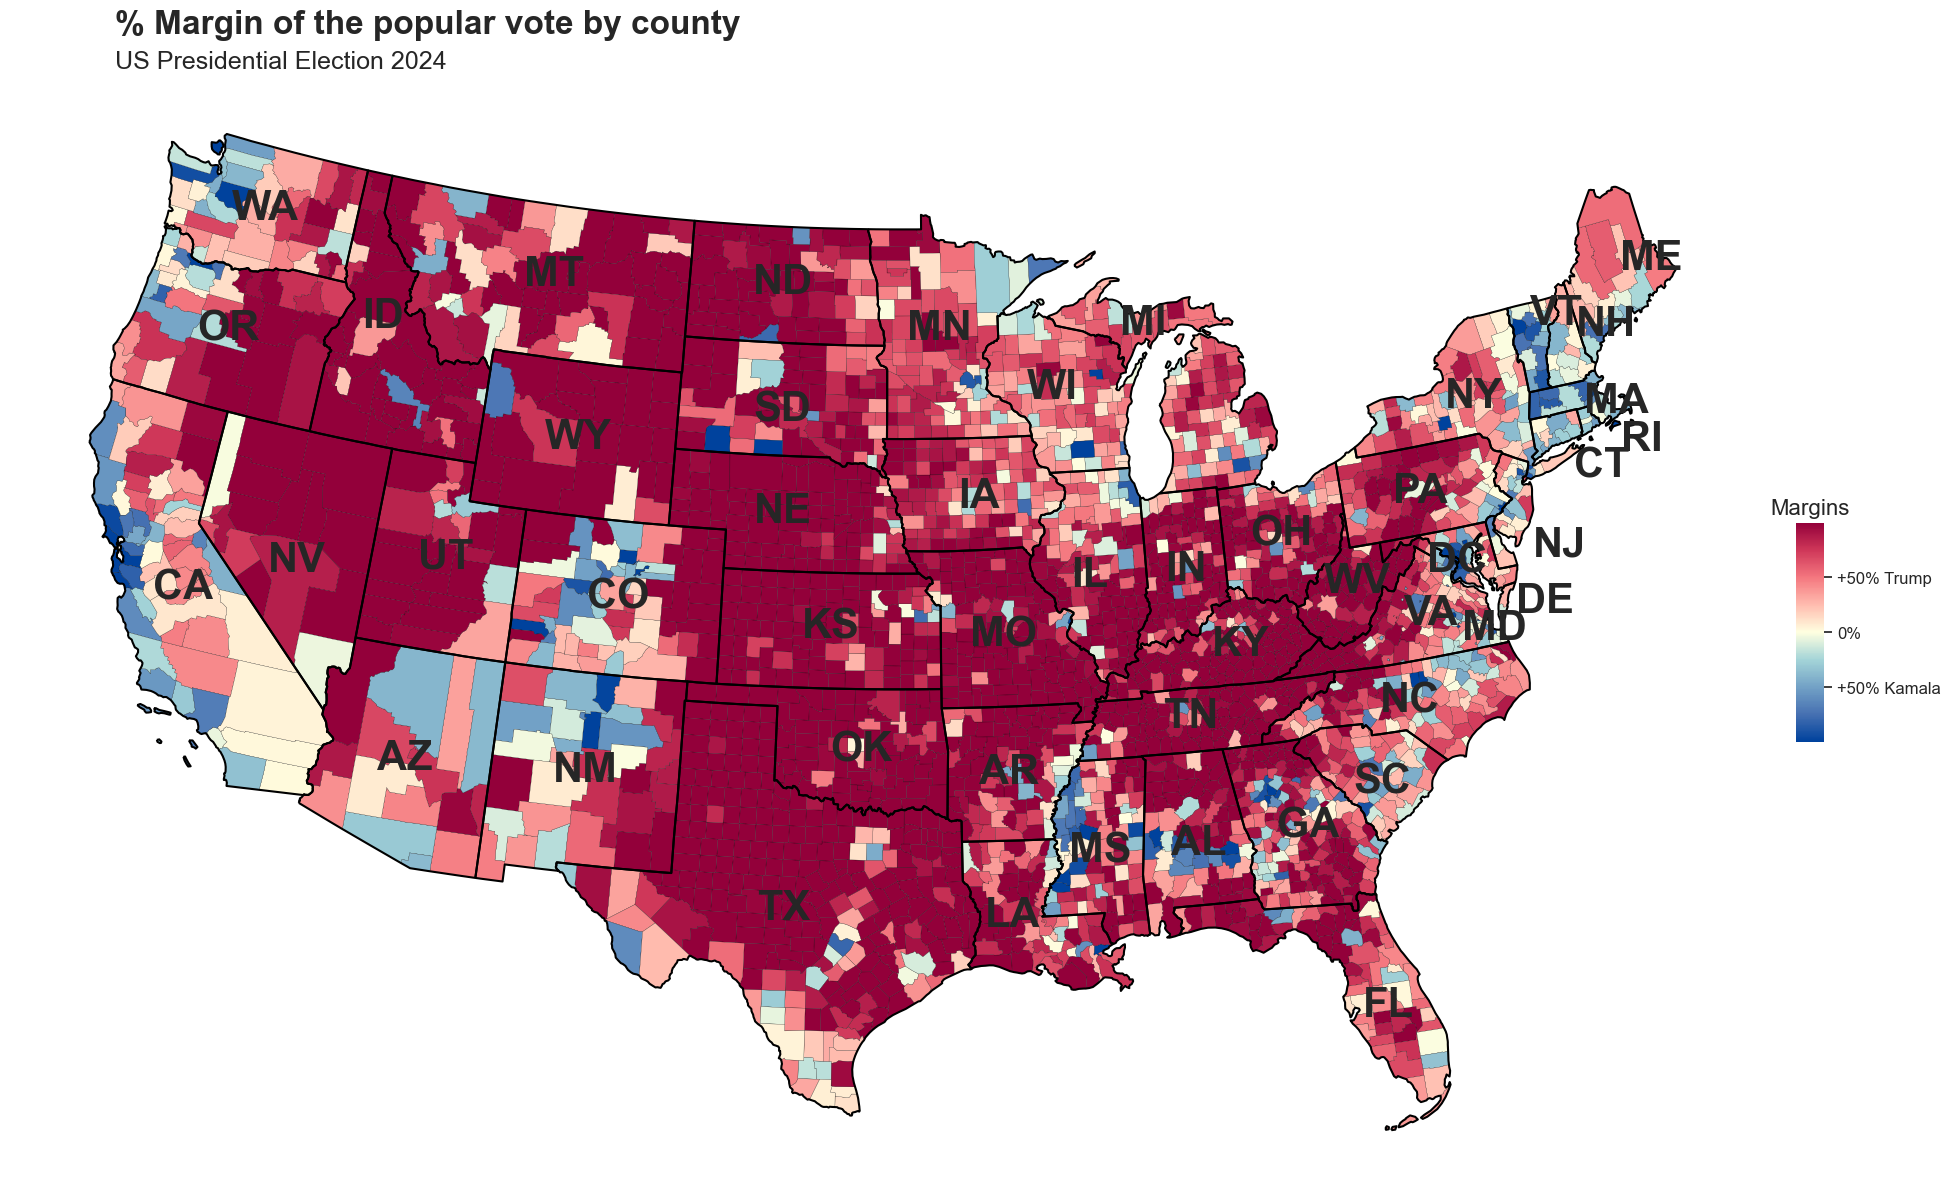

In [38]:


url = "https://www2.census.gov/geo/tiger/GENZ2024/shp/cb_2024_us_county_20m.zip"
counties_gdf = gpd.read_file(url)
print(counties_gdf.head())

# Contiguous US only (drop AK, HI, PR)
counties_contig = counties_gdf[~counties_gdf['STATEFP'].isin(['02','15','72'])].copy()

my_scale = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8',
            '#ffffe0', '#ffbcaf', '#f4777f', '#cf3759', '#93003a']
party_colours = ["#2E74C0", "#CB454A"] 

# Expecting us_elections_2024 to exist already:
#   columns: county_fips, votes_gop, votes_dem
us_elections_2024['GEOID'] = us_elections_2024['county_fips'].astype(str).str.zfill(5)

# If you have per_gop/per_dem instead, comment the next 4 lines and use the two lines below them.
us_elections_2024['margin'] = (
    (us_elections_2024['votes_gop'] - us_elections_2024['votes_dem']) /
    (us_elections_2024['votes_gop'] + us_elections_2024['votes_dem'])
) * 100

# Alternative if percentages are already in the data:
# us_elections_2024['margin'] = (us_elections_2024['per_gop'] - us_elections_2024['per_dem']) * 100

results = us_elections_2024[['GEOID','margin']].copy()


# Join + project

merged = counties_contig.merge(results, on='GEOID', how='left')
merged = merged.to_crs('ESRI:102003')  # Albers Equal Area (contiguous USA)

#plot

fig, ax = plt.subplots(figsize=(22, 12))

# Diverging palette centered at 0 (negatives → blue, positives → red)
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
cmap = LinearSegmentedColormap.from_list("smooth_map", my_scale, N=256)
norm = TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)

# Counties
merged.plot(
    column='margin',
    cmap=cmap,
    norm=norm,
    ax=ax,
    edgecolor='black',
    linewidth=0.15,
    legend=False,
    missing_kwds={'color':'#dddddd','edgecolor':'none'}
)

# State outlines 
states_outline = counties_contig.dissolve(by='STATEFP').to_crs('ESRI:102003')
states_outline.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)

# State abbreviations
states_labels = gpd.read_file(
    "https://www2.census.gov/geo/tiger/GENZ2024/shp/cb_2024_us_state_20m.zip"
)
states_labels = states_labels[~states_labels['STUSPS'].isin(['AK','HI','PR'])].to_crs('ESRI:102003')
states_labels['pt'] = states_labels.geometry.representative_point()

adjustments = {
    'ME': (80000, 50000),
    'VT': (70000, 90000),
    'NH': (120000, 30000),
    'MA': (140000, -10000),
    'RI': (150000, -50000),
    'CT': (130000, -90000),
    'NJ': (110000, -130000),
    'DE': (140000, -170000),
    'MD': (100000, -210000),
}

for _, r in states_labels.iterrows():
    x, y = r.pt.x, r.pt.y
    if r['STUSPS'] in adjustments:
        dx, dy = adjustments[r['STUSPS']]
        x += dx
        y += dy
    ax.text(x, y, r['STUSPS'],
            ha='center', va='center',
            fontsize=30, fontweight='bold')
    

# Titles
ax.text(0.06, 1.04, "% Margin of the popular vote by county",
        transform=ax.transAxes, fontsize=24, ha='left', va='bottom', weight='bold')
ax.text(0.06, 1.01, "US Presidential Election 2024",
        transform=ax.transAxes, fontsize=18, ha='left', va='bottom')
ax.set_axis_off()
# Custom legend: "+50% Trump / 0% / +50% Kamala"
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, ax=ax, fraction=0.015, pad=0.02, shrink=0.2, aspect=8)
cb.ax.set_title("Margins", fontsize=16, pad=6)
cb.set_ticks([-25, 0, 25])
cb.set_ticklabels(["+50% Kamala", "0%", "+50% Trump"])
cb.outline.set_visible(False)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(12)


plt.tight_layout()
plt.show()


# A specific analysis to compare county-level voting margins between two elections.

I want you to create an interactive plot that compares the 2024 vs 2020 US Presidential Election at the county level. Your plot should look like the one shown below (Loving, Texas was randomly chosen!)

In [39]:

# Display the image

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [40]:
# Load  data

# Load the dataset from the relevant directory
df_2020 = pd.read_csv('data/2020_US_County_Level_Presidential_Results.csv')
df_2024 = pd.read_csv('data/2024_US_County_Level_Presidential_Results.csv')


# Printing out the first 10 observations of the 2020 dataset
df_2020.head(10)

# Margin calc
df_2020['margin_2020'] = df_2020['per_gop'] - df_2020['per_dem']
df_2024['margin_2024'] = df_2024['per_gop'] - df_2024['per_dem']

# Merge into one dataframe
df = df_2020[['county_fips', 'county_name', 'state_name', 'margin_2020', 'total_votes']].merge(
    df_2024[['county_fips', 'margin_2024']],
    on='county_fips'
)

# Calculate shift
df['shift'] = df['margin_2024'] - df['margin_2020']

# Winner calculation
df['winner_2024'] = df['margin_2024'].apply(lambda x: 'Trump' if x > 0 else 'Harris')

In [41]:
fig = px.scatter(
    df,
    x='margin_2020',
    y='margin_2024',
    color='winner_2024',
    # size='total_votes',
    size_max=45,
    hover_name='county_name',
    title='US Presidential Election Margins: 2020 vs 2024',
    labels={
        'margin_2020': '2020 Margin (Trump - Biden)',
        'margin_2024': '2024 Margin (Trump - Harris)',
        'winner_2024': '2024 Winner'
    },

    color_discrete_map={'Trump': '#d62728', 'Harris': '#1f77b4'},
    template='plotly_white',
    width=1000,
    height=700
)

# Improve marker visibility
fig.update_traces(
    marker=dict(
        sizemin=6,
        opacity=0.75,
        line=dict(width=0.3, color='white')
    ),
    selector=dict(mode='markers')
)
# Diagonal, No change line
fig.add_trace(
    go.Scatter(
        x=[-1, 1],
        y=[-1, 1],
        mode='lines',
        line=dict(color='gray', width=2, dash='dash'),
        name='No Change',
        hoverinfo='skip'
    )
)

# Convert axes to percentages
fig.update_xaxes(tickformat='.0%', range=[-1, 1])
fig.update_yaxes(tickformat='.0%', range=[-1, 1])

#save plot
fig.write_html('election_comparison.html')
fig.show()

# Electricity, emissions, and GDP


In [42]:
##import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import plotly.express as px
import geopandas as gpd
import wbgapi as wb
import country_converter as coco

The final interactive web: https://data-visualization-zfxyrvv2ongmecdowvjvmy.streamlit.app/

In [43]:
##define global color palette
fuel_color_palette = {
    # Fossil Fuels
    'coal': '#A0522D',      # Brown (Sienna)
    'oil': '#36454F',       # Dark Grey (Charcoal)
    'gas': '#6B9BD1',       # Soft Blue (like a natural gas flame)

    # Renewables
    'hydro': '#0077BE',     # Deep Blue (water)
    'solar': '#FFA500',     # Orange (sun, more distinct than yellow)
    'wind': '#A8D5E2',      # Light Sky Blue (air/sky)
    'biofuel': '#556B2F',    # Dark Green (biomass)
    'other_renewable': '#20B2AA', # Teal (general renewable)

    # Other
    'nuclear': '#E91E63'    # Pink/Magenta (a distinct, high-energy color)
}


In [44]:
##import required data
co2_df = pd.read_csv("https://ourworldindata.org/grapher/co-emissions-per-capita.csv?v=1&csvType=full&useColumnShortNames=true")
co2_df.columns = (co2_df.columns.str.strip().str.lower().str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\s+', '_', regex=True))
co2_df = co2_df.rename(columns={'emissions_total_per_capita': 'co2_per_capita', 'entity': 'country', 'code': 'iso_code'})\
    .query("year >= 1990")

energy_df = pd.read_csv("https://nyc3.digitaloceanspaces.com/owid-public/data/energy/owid-energy-data.csv")
energy_df.columns = energy_df.columns.str.strip().str.lower().str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\s+', '_', regex=True)
energy_df = energy_df.query("year >= 1990")\
    .dropna(subset=['iso_code'])\
    .rename(columns={ # We rename the long electricity source columns to be short and simple
        'biofuel_electricity': 'biofuel', 'coal_electricity': 'coal', 'gas_electricity': 'gas',
        'hydro_electricity': 'hydro', 'nuclear_electricity': 'nuclear', 'oil_electricity': 'oil',
        'other_renewable_exc_biofuel_electricity': 'other_renewable',
        'solar_electricity': 'solar', 'wind_electricity': 'wind'
    })


indicator_id = 'NY.GDP.PCAP.PP.KD'
gdp_percap_df = wb.data.DataFrame(
    indicator_id,
    time=range(1990, 2024),
    skipBlanks=True,
    columns='series'
)
gdp_percap_df = gdp_percap_df.reset_index().rename(columns={
    'economy': 'iso_code',
    'time': 'year',
    indicator_id: 'GDPpercap'
})
gdp_percap_df['year'] = gdp_percap_df['year'].str.replace('YR', '', regex=False).astype(int)



In [45]:
#prepare data for analysis
energy_df_new = energy_df[['country', 'year', 'iso_code', 'population', 'gdp', 'biofuel', 'coal','gas', 'hydro', 'nuclear', 'oil', 'other_renewable', 'solar', 'wind']].\
            melt(id_vars=['country', 'year', 'iso_code', 'population', 'gdp'], var_name='source',value_name='value').\
            dropna(subset=['value', 'iso_code']).reset_index()
energy_df_new.head()

,index,country,year,iso_code,population,gdp,source,value
0,10,Afghanistan,2000,AFG,20130279.0,1.128379e+10,biofuel,0.0
1,11,Afghanistan,2001,AFG,20284252.0,1.102127e+10,biofuel,0.0
2,12,Afghanistan,2002,AFG,21378081.0,1.880487e+10,biofuel,0.0
3,13,Afghanistan,2003,AFG,22733007.0,2.107434e+10,biofuel,0.0
4,14,Afghanistan,2004,AFG,23560598.0,2.233257e+10,biofuel,0.0


In [46]:
#prepare data for analysis
data_1 = energy_df_new.merge(co2_df.drop(columns=['country']), on=['iso_code', 'year'], how='inner')
data = data_1.merge(gdp_percap_df, on=['iso_code', 'year'], how='inner')
data.head()

,index,country,year,iso_code,population,gdp,source,value,co2_per_capita,GDPpercap
0,10,Afghanistan,2000,AFG,20130279.0,1.128379e+10,biofuel,0.0,0.052017,1617.826475
1,11,Afghanistan,2001,AFG,20284252.0,1.102127e+10,biofuel,0.0,0.052706,1454.110782
2,12,Afghanistan,2002,AFG,21378081.0,1.880487e+10,biofuel,0.0,0.062727,1774.308743
3,13,Afghanistan,2003,AFG,22733007.0,2.107434e+10,biofuel,0.0,0.068605,1815.928200
4,14,Afghanistan,2004,AFG,23560598.0,2.233257e+10,biofuel,0.0,0.052513,1776.918207


In [47]:
#data visualization 1——Electricity Production Mix by Country and Year

country_options = data['country'].unique()
selected_country = st.selectbox("Select Country", country_options)
filtered_data = data[data['country'] == selected_country]

fig1 = px.area(filtered_data,x='year',y='value',color='source',
    labels={'year': 'Year','value': 'Electricity Production (TWh)','source': 'Energy Source'},
    title='Electricity Production Mix by Country and Year',
    color_discrete_sequence=list(fuel_color_palette.values()),
    category_orders={'source':['biofuel','coal','gas','hydro','nuclear','oil','other_renewable','solar','wind'][::-1]},
    template='plotly_white')
fig1.update_layout(legend=dict(traceorder='reversed'))
fig1.update_traces(line=dict(width=0))
fig1.write_html('energy_Production.html')
fig1.show()

2025-11-10 18:50:43.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.578 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.579 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [48]:
co2_gdp_df = co2_df.merge(gdp_percap_df,on=['iso_code','year'],how='inner')

In [49]:
#data visualization 2: the relationship between emission and gdp
fig2 = px.scatter(co2_gdp_df[co2_gdp_df['country']==selected_country], x='co2_per_capita', y='GDPpercap',
    labels={'GDPpercap':'GDP Per Capita','co2_per_capita':'CO2 Per Capita'},
    title='The Relationship between Emission and Economic Development',
    template='plotly_white')


In [50]:
#Data Visualization 3: The relationship between electricity and gdp
data3 = data.groupby(['iso_code','year'])['value'].sum().reset_index().\
    rename(columns={'value':'elec'}).\
    merge(co2_gdp_df,on=['iso_code','year'],how='inner')
fig3 = px.scatter(data3[data3['country']==selected_country],x='elec',y='GDPpercap',
    labels={'GDPpercap':'GDP Per Capita','co2_per_capita':'CO2 Per Capita','elec':'Electricity Production (TWh)'},
    title='The Relationship between Electricity Production and Economic Development',
    template='plotly_white')

In [51]:
st.plotly_chart(fig1, use_container_width=True)
col1, col2 = st.columns(2)
col1.plotly_chart(fig2, use_container_width=True)
col2.plotly_chart(fig3, use_container_width=True)

2025-11-10 18:50:43.698 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.698 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 18:50:43.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()